# Dashote case study: Burritos

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
import missingno as msno 
import warnings

In [2]:
# Font
import matplotlib
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'Times New Roman'

In [3]:
path = r'C:\Users\marco\OneDrive\Desktop\Dashmote\Dashmote_burrito.xlsx'
file = pd.read_excel(path)
df = pd.DataFrame(file)

# 1. Cleaning and data quality analysis

In [4]:
# Empty or not useful column to be removed
for column in df.columns:
    if df[column].empty == True or df[column].isnull().values.all():
        print(column)

Queso


In [5]:
# Remove 'Queso' column
df.drop('Queso', axis = 1, inplace = True)

## Syntax errors

In [6]:
# Check date and make theme homogenous -> type: datatime
from datetime import datetime
for i,date in enumerate(df['Date']):
    if type(date) == str:
        date_time = datetime(int(date.split('/')[2]), int(date.split('/')[0]), int(date.split('/')[1]), 0, 0)
        df.at[i,'Date'] = date_time

# Check Burritos names and make theme homogenous
for i,burrito in enumerate(df['Burrito']):
    if burrito[-1] == ' ':                   # common typo
        burrito = burrito[:len(burrito)-1]
        df.at[i, 'Burrito'] = burrito
    df.at[i, 'Burrito'] = burrito.upper()    # get rid of uppercase/lowercase errors
    
# Similarly, check reviewers names and make theme homogenous
for i,reviewer in enumerate(df['Reviewer']):
    if reviewer != False:
        if reviewer[-1] == ' ':
            df.at[i, 'Reviewer'] = reviewer[:len(burrito)-1]
        df.at[i, 'Reviewer'] = reviewer.upper()
        
# Check scores are all under 5 and over 0 
errors = 0
column_list = ['Yelp','Google','Hunger','Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'overall']
for column in column_list:
    for i,element in enumerate(df[column].values):
        if (element > 5 or element < 0):
            print('Error: ', column, element, i)
            errors = errors + 1
if errors == 0:
    print('No errors') 
    
# Check if columns have the correct data type to detect. I check manually the first row, all data types were correct.
str_or_bool_ = []
float_ = []
for element, column_name in zip(df.iloc[0,:], df.columns):
    if type(element) == str or type(element) == bool:
        str_or_bool_.append(column_name)
    elif type(element) == float:
        float_.append(column_name)
for column in str_or_bool_:

    for i,element in enumerate(df[column]):
        if type(element) != bool and type(element) != str:
            print('error:', column,  element, i) 
for column in float_:
    for i,element in enumerate(df[column]):
        if type(element) != float:
            print('error:', 'column:', column, 'el:', i, 'value:',  element) 

TypeError: 'float' object is not subscriptable

In [ ]:
# set to nan outliers
df['Tortilla'].values[131] = np.NaN
df['overall'].values[34] =   np.NaN
df['Rec'].values[131] = False

## Data completion

In [1862]:
# Binarizes columns with 'x' 
warnings.simplefilter(action='ignore', category=FutureWarning)
x_list = ['Chips','Unreliable', 'NonSD', 'Beef', 'Pico',
       'Guac', 'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp',
       'Fish', 'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster',
       'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini']
for column in x_list:
    if 'x' in np.array(df[column]) or 'X' in np.array(df[column]):
        df[column] = df[column].replace(('x','X'), 1)
        df[column] = df[column].replace(np.nan, 0)

In [1863]:
# Group ingredients to check how much data is available about them. 
beef = df.columns.get_loc('Beef')
n_toppings = np.sum(np.array(df.iloc[:,beef:]), axis = 1)
for i in range(len(n_toppings)):
    if n_toppings[i] < 1: n_toppings[i] = np.NaN # if n_ingredients<1, data not available
df_ = df_[df_.columns[:df_.columns.get_loc("Notes")+1]]
df_['toppings'] = n_toppings # temp df to check data completion

<AxesSubplot:>

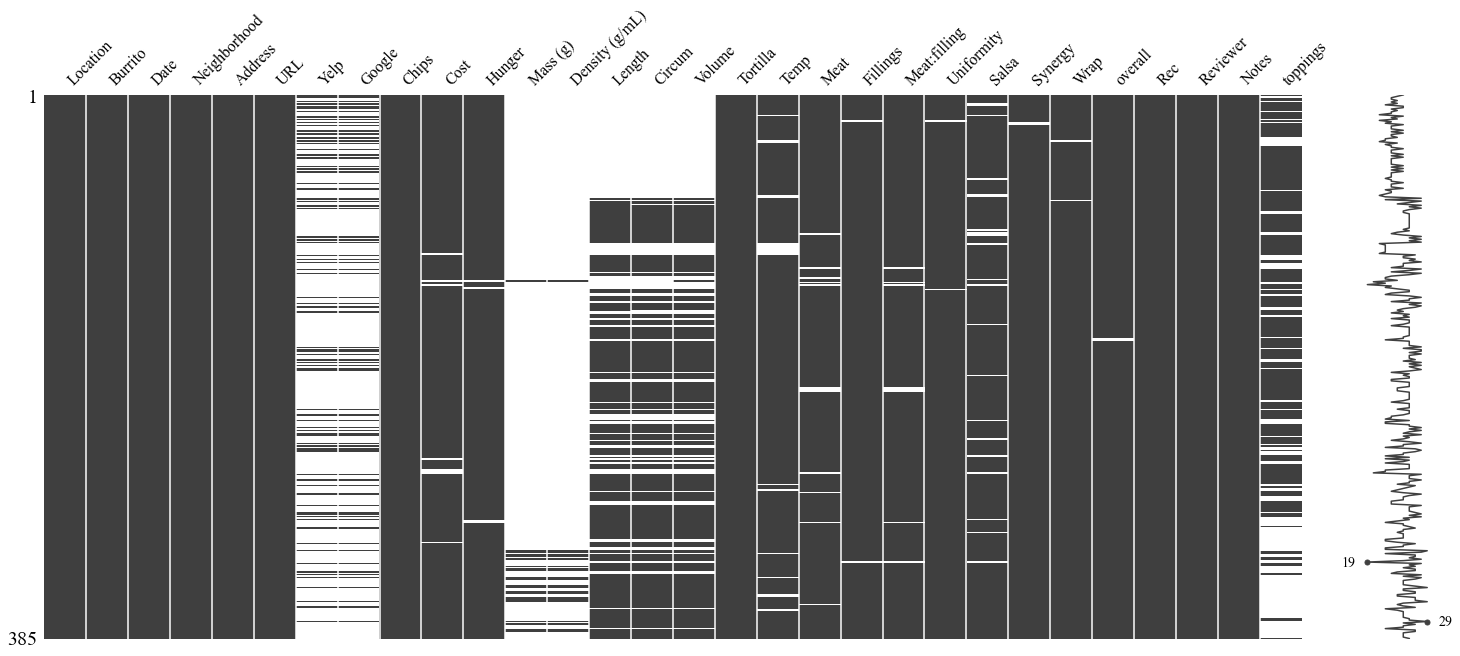

In [1864]:
# Nullity matrix
msno.matrix(df_)

Nullity matrix. Quick view of data completion. Toppings, as already descbired, were grouped. 

Most important considerations:

- Mass and Density data are not enough to obtain statistically relevant results and will be removed. Only lately collection of this type of data has been performed. This data could reflect the aboundance of ingredients, likely a feature that have an impact on costumer's reviwes.

- Important data for the burrito's evaluation, like Yelp and Google reviews and reviewers' marks are not complete. 

In [1865]:
# Remove Mass and Density
df.drop(df.columns[df.columns.get_loc('Mass (g)')], axis = 1, inplace = True)
df.drop(df.columns[df.columns.get_loc('Density (g/mL)')], axis = 1, inplace = True)

<AxesSubplot:>

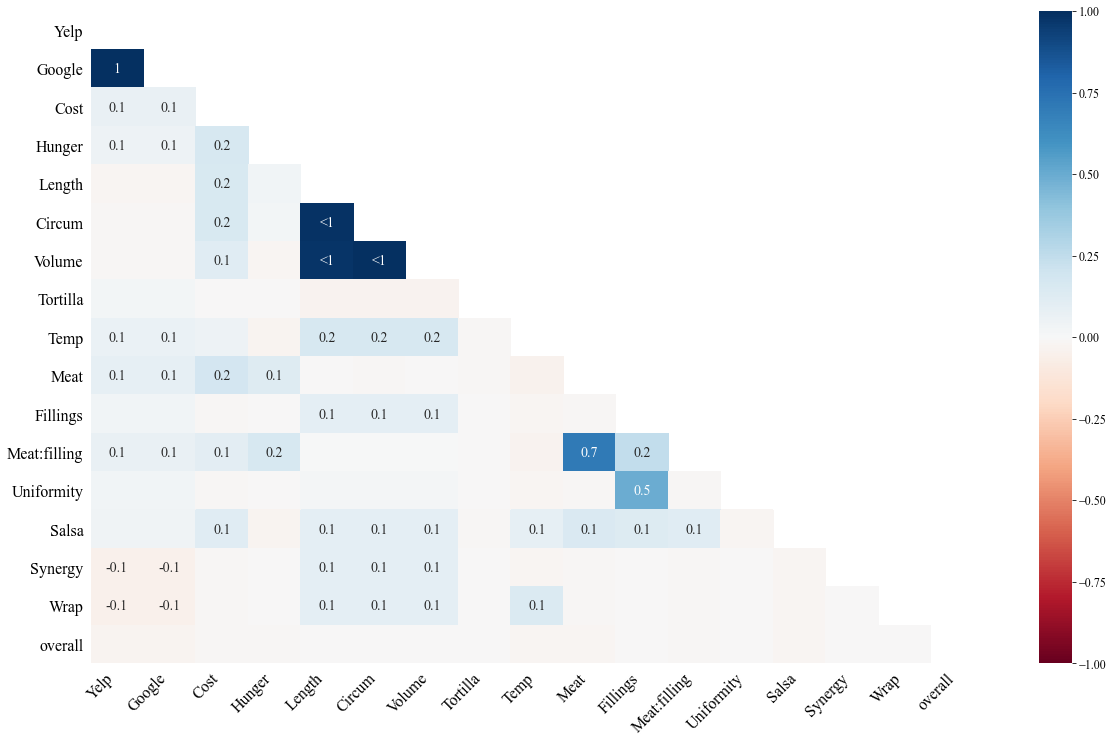

In [1866]:
msno.heatmap(df)

Nullity correlation. Considerations:

- Yelp and Google reviews have perfect correlation. This will be useful during analysis.

- Surprisingly the location (Neighborhood, address) is provided almost only when URL and web reviews are provided. 

Final comment: 
    
- Data are not complete. However all columns now have enough data to be statistically significant.

- Syntax errors that could be detected were adressed and solved


# 2. Data Analysis

## Ingredients Analysis

In [1867]:
df_review = df[['Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'overall']]
df_review.corr(method = 'pearson')['overall']

Tortilla       -0.022416
Temp            0.058810
Meat            0.025717
Fillings       -0.045667
Meat:filling    0.023649
Uniformity     -0.084844
Salsa           0.014730
Synergy        -0.008631
Wrap            0.045725
overall         1.000000
Name: overall, dtype: float64

Synergy, Fillings and Meat are the features of a burrito that have the biggest impact on the overall result. 

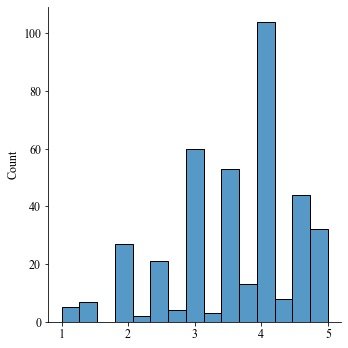

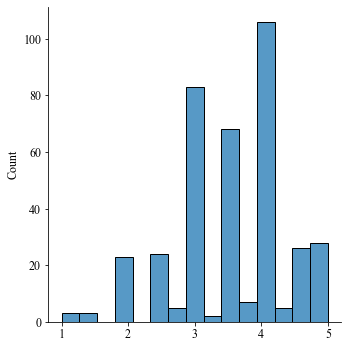

In [1847]:
# Look at the sinergy distribution and see which ingredients combination return the biggest sinergy. 
# Fillings same
sns.displot(df['Synergy'].values)
sns.displot(df['Fillings'].values)

In [1848]:
# Quartiles
synergy = df['Synergy'].values[~np.isnan(df['Synergy'].values)]   
fillings = df['Fillings'].values[~np.isnan(df['Fillings'].values)]   
syn_q1 = np.percentile(synergy,25)
syn_q4 = np.percentile(synergy, 75)
fil_q1 = np.percentile(fillings,50)
fil_q4 = np.percentile(fillings, 50)
# Indexes
good_syn = df['Synergy'].index[df['Synergy'].values > syn_q4]
bad_syn = df['Synergy'].index[df['Synergy'].values < syn_q1]
good_fil = df['Fillings'].index[df['Fillings'].values > fil_q4]
bad_fil = df['Fillings'].index[df['Fillings'].values < fil_q1]

<AxesSubplot:xlabel='toppings', ylabel='Count'>

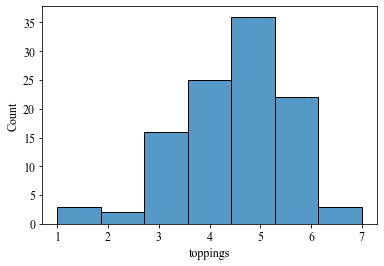

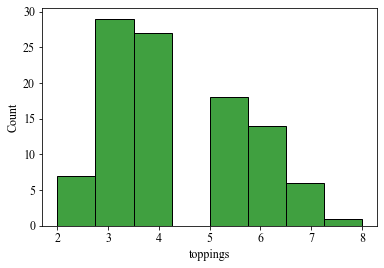

In [1849]:
# number of toppings
plt.figure()
sns.histplot(df_['toppings'][good_fil], bins = 7)
plt.figure()
sns.histplot(df_['toppings'][bad_fil], color = 'green', bins = 8)

In [1850]:
# Combination of ingredients with synergy
ingredients_list = ['Beef', 'Pico',
       'Guac', 'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp',
       'Fish', 'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster',
       'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini']
df[ingredients_list].iloc[good_syn].sum(axis = 0)

Beef             33.0
Pico             21.0
Guac             25.0
Cheese           37.0
Fries            29.0
Sour cream       24.0
Pork              5.0
Chicken           4.0
Shrimp            1.0
Fish              3.0
Rice              5.0
Beans             2.0
Lettuce           4.0
Tomato            2.0
Bell peper        1.0
Carrots           0.0
Cabbage           2.0
Sauce             8.0
Salsa.1           0.0
Cilantro          2.0
Onion             2.0
Taquito           1.0
Pineapple         0.0
Ham               0.0
Chile relleno     3.0
Nopales           0.0
Lobster           0.0
Egg               1.0
Mushroom          1.0
Bacon             1.0
Sushi             0.0
Avocado           1.0
Corn              0.0
Zucchini          1.0
dtype: float64

In [1851]:
df[ingredients_list].iloc[bad_syn].sum(axis = 0)

Beef             29.0
Pico             27.0
Guac             24.0
Cheese           28.0
Fries            18.0
Sour cream       15.0
Pork             11.0
Chicken           6.0
Shrimp            4.0
Fish              0.0
Rice              9.0
Beans            12.0
Lettuce           3.0
Tomato            1.0
Bell peper        2.0
Carrots           1.0
Cabbage           0.0
Sauce             5.0
Salsa.1           3.0
Cilantro          3.0
Onion             4.0
Taquito           0.0
Pineapple         0.0
Ham               0.0
Chile relleno     0.0
Nopales           0.0
Lobster           0.0
Egg               1.0
Mushroom          2.0
Bacon             1.0
Sushi             0.0
Avocado           2.0
Corn              0.0
Zucchini          0.0
dtype: float64

In [1852]:
# Calculate correlation among ingredients where synergy is good (measure of frequency of combos)
# Calculate correlation among ingredients where synergy is bad (measure of frequency of combos)
# If we look where the difference is the biggest, we get the pattern that usually make a burrito Synergic
statistical_significant_list = ['Beef', 'Pico',
       'Guac', 'Cheese', 'Fries', 'Sour cream']
combos = df[statistical_significant_list].iloc[good_syn].corr() - df[statistical_significant_list].iloc[bad_syn].corr()
list(zip(combos.max(axis = 0), combos.idxmax(axis = 0), combos.columns))

[(0.35281760337500906, 'Guac', 'Beef'),
 (0.363926246848969, 'Cheese', 'Pico'),
 (0.5790320378655704, 'Cheese', 'Guac'),
 (0.5790320378655704, 'Guac', 'Cheese'),
 (0.4281840425623017, 'Guac', 'Fries'),
 (0.3503229743850305, 'Pico', 'Sour cream')]

These four combination represents the most relevant patterns that distinguish good synergy burritos from bad synergy burritos.
Good synegy has a huge impact on overall reviews. In addition, the choice of 5-6 ingredients is statistically more appreciated.These analysis was also conducted only on California burritos and the combination were the same.

## Does hunger impact reviews?

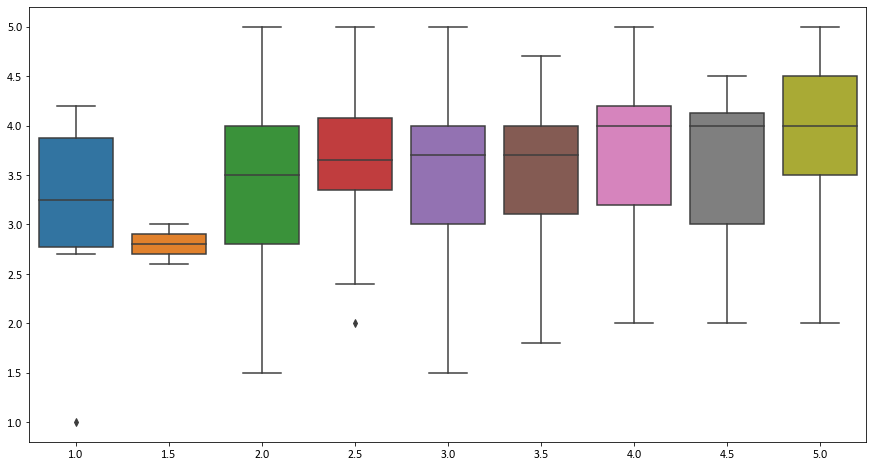

In [1746]:
# Hunger-Review
lista = []
for vol, overall in zip(df['Hunger'].values, df['overall'].values):
    if not (math.isnan(vol) or math.isnan(overall)) and (vol/0.5).is_integer():
        lista.append([vol, overall ])
lista.sort()
vol = [lista[i][0] for i in range(len(lista))]
review = [lista[i][1] for i in range(len(lista))]
plt.figure(figsize = (15,8))
sns.boxplot(vol,review)
plt.show()

In [1738]:
import scipy.stats as stats
a = []
c = []
d =[]
e = []
f = []
g =[]
h = []
i = []
for  n,value in enumerate(vol):
    if value == 1.0:
        a.append(review[n])
    elif value == 2.0:
        c.append(review[n])
    elif value == 2.5:
        d.append(review[n])
    elif value == 3.0:
        e.append(review[n])
    elif value == 3.5:
        f.append(review[n])
    elif value == 4.0:
        g.append(review[n])
    elif value == 4.5:
        h.append(review[n])
    elif value == 5.0:
        i.append(review[n])
fvalue, pvalue = stats.f_oneway(a,c,d,e,f,g,h,i)
print(fvalue, pvalue)

1.5817051512178015 0.1396920417937249


p-value > 0.1. Suprisingly the hunger, statisically, does not influence the judgement of the burritos. Hunger = 1.5 not analyzed (only 1 samples).

## Trends analysis burrito

In [1739]:
count = []
for burrito in list(set(df['Burrito'])):
    count.append([df['Burrito'].values.tolist().count(burrito), burrito])
count.sort(reverse = True)
print(count[:15])

[[117, 'CALIFORNIA'], [33, 'CARNE ASADA'], [17, 'CARNITAS'], [17, 'CALIFORNIA EVERYTHING'], [15, 'SURF & TURF'], [13, 'LOCAL'], [11, 'AL PASTOR'], [8, 'SURFIN CALIFORNIA'], [8, 'ADOBADA'], [5, 'HOLY MOLY'], [4, 'CUSTOM'], [4, 'CARNE ASADA EVERYTHING'], [3, 'SURF AND TURF'], [3, 'PASTOR'], [3, 'FISH']]


<AxesSubplot:xlabel='Burrito', ylabel='count'>

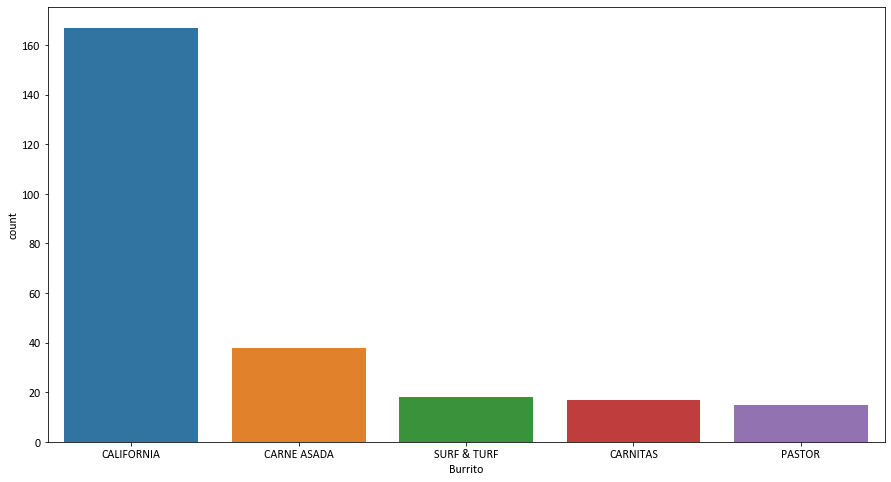

In [1740]:
for i,burrito in enumerate(df['Burrito']):    
    if burrito.find('CALIFORNIA') != -1:  #california could be surf and turf but I'll count it as california 
        df.at[i, 'Burrito'] = 'CALIFORNIA'
    elif burrito.find('CARNE ASADA') != -1:
        df.at[i, 'Burrito'] = 'CARNE ASADA'
    elif burrito.find('SURF') != -1 and burrito.find('TURF') != -1:
        df.at[i, 'Burrito'] = 'SURF & TURF'
    elif burrito.find('PASTOR') != -1:
        df.at[i, 'Burrito'] = 'PASTOR'
plt.figure(figsize = (15,8))
sns.countplot(df['Burrito'], order=pd.value_counts(df['Burrito']).iloc[:5].index)

In [1755]:
# create dataset of 2016 and a dataset of 2017
df_2016 = df.iloc[[df['Date'].values[i].find('16/') != -1 or df['Date'].values[i].find('/2016') != -1 for i in range(len(df))], :]
df_2017 = df.iloc[[df['Date'].values[i].find('17/') != -1 or df['Date'].values[i].find('/2017') != -1 for i in range(len(df))], :]

<AxesSubplot:xlabel='Burrito', ylabel='count'>

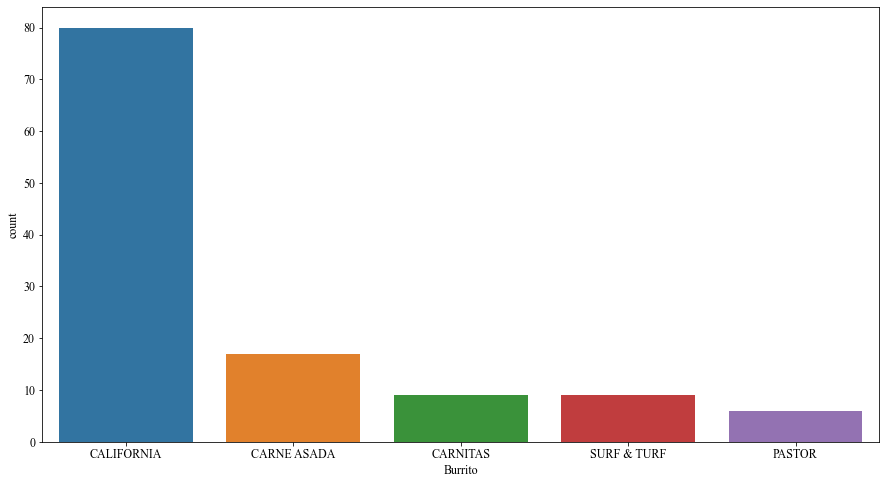

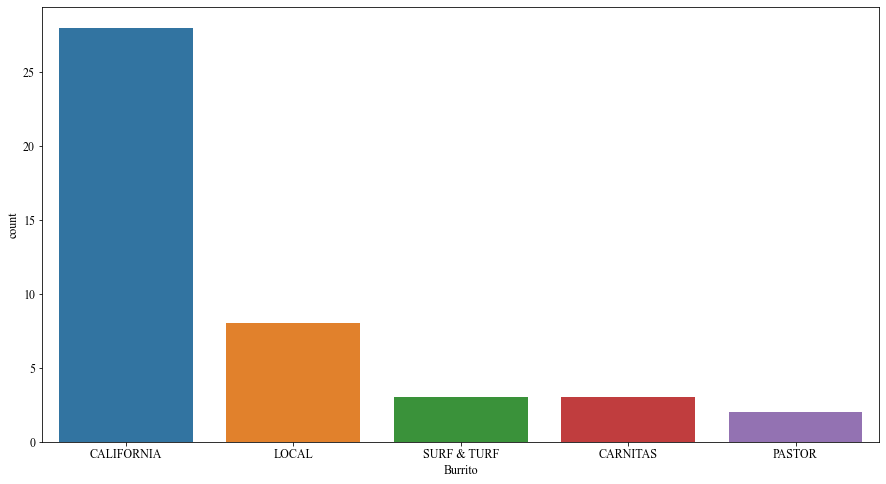

In [1756]:
plt.figure(figsize = (15,8))
sns.countplot(df_2016['Burrito'], order=pd.value_counts(df_2016['Burrito']).iloc[:5].index)
plt.figure(figsize = (15,8))
sns.countplot(df_2017['Burrito'], order=pd.value_counts(df_2017['Burrito']).iloc[:5].index)

California is dominant. Local in 2017 became the second most common burrito. 

In [1743]:
df_local = df[df['Burrito'].values == 'LOCAL']
df_carne_asada = df[df['Burrito'].values == 'CARNE ASADA']
print(np.mean(df_local['overall'].values))
overall = df['overall'].values[~np.isnan(df['overall'].values)]   
print(np.mean(overall))
fvalue, pvalue = stats.f_oneway(df_local['overall'].values, overall)
print(fvalue, pvalue)
fvalue, pvalue = stats.f_oneway(df_local['overall'].values, df_carne_asada['overall'].values)
print(fvalue, pvalue)

4.146153846153846
3.606047120418848
6.442403371350761 0.011527988666646826
7.402694191883058 0.008989189450091922


p-value < 0.05.Local in addition has a statistically higher average mark compared to the entire dataset average. Same for the carne asada. 

## Yelp/Google review

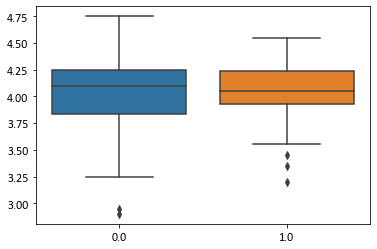

In [1744]:
chips_yes = []
chips_no = []
for i,row in enumerate(zip(df['Chips'], df['Yelp'])):
    if (row[0]==1 and ~np.isnan(row[1])):
        chips_yes.append(i)
    elif (row[0]==0 and ~np.isnan(row[1])):
        chips_no.append(i)
        
sns.boxplot(df['Chips'].values,  (df['Yelp'].values + df['Google'].values)/2)
review_no = (df.loc[chips_no,'Yelp'] + df.loc[chips_no, 'Google'])/2
review_yes = (df.loc[chips_yes,'Yelp'] + df.loc[chips_yes, 'Google'])/2

In [1705]:
fvalue, pvalue = stats.f_oneway(review_yes, review_no)
print(fvalue, pvalue)

0.02797328660317478 0.8675936932850541


Chips does not make any difference. Let's see if their price is higher or equal to the food served without chips. If it's the same not serving chips coul allow to reduce price and increase competivity.

2.4814256770718566 0.11914436304941511


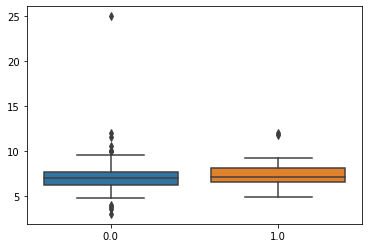

In [1706]:
sns.boxplot(df['Chips'].values,  df['Cost'].values)
cost_no = df.loc[chips_no,'Cost'] 
cost_yes = df.loc[chips_yes,'Cost'] 
fvalue, pvalue = stats.f_oneway(cost_yes, cost_no)
print(fvalue, pvalue)

p-value > 0.1. Not statistically price difference. Then the previous deduction is confirmed.

# Summary

### A. Preprocessing and data quality

First of all, the empty columns were removed ('Queso' column). Secondly, data non-uniformities were correc

## Annex

In [1233]:
# Let's have a closer look to California, when they work when they don't
df_review_cal = df[['Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'overall']]
df_review_cal = df_review_cal.iloc[california]
# Interesting
df_review_cal.corr(method = 'pearson')['overall']

Tortilla        0.376160
Temp            0.100626
Meat            0.564614
Fillings        0.616217
Meat:filling    0.398021
Uniformity      0.358769
Salsa           0.257406
Synergy         0.653901
Wrap           -0.010973
overall         1.000000
Name: overall, dtype: float64

In [ ]:
# Quartiles
synergy = df_review_cal['Synergy'].values[~np.isnan(df['Synergy'].values)]   
fillings = df_review_cal['Fillings'].values[~np.isnan(df['Fillings'].values)]   
syn_q1 = np.percentile(synergy,25)
syn_q4 = np.percentile(synergy, 75)
fil_q1 = np.percentile(fillings,50)
fil_q4 = np.percentile(fillings, 50)
# Indexes
good_syn = df_review_cal['Synergy'].index[df_review_cal['Synergy'].values > syn_q4]
bad_syn = df_review_cal['Synergy'].index[df_review_cal['Synergy'].values < syn_q1]
good_fil = df_review_cal['Fillings'].index[df_review_cal['Fillings'].values > fil_q4]
bad_fil = df_review_cal['Fillings'].index[df_review_cal['Fillings'].values < fil_q1]

In [1237]:
statistical_significant_list = ['Beef', 'Pico',
       'Guac', 'Cheese', 'Fries', 'Sour cream']
combos = df[statistical_significant_list].iloc[good_syn].corr() - df[statistical_significant_list].iloc[bad_syn].corr()
list(zip(combos.max(axis = 0), combos.idxmax(axis = 0), combos.columns))

[(0.30525378951014503, 'Guac', 'Beef'),
 (0.28527338499214744, 'Sour cream', 'Pico'),
 (0.37249246395939045, 'Cheese', 'Guac'),
 (0.37249246395939045, 'Guac', 'Cheese'),
 (0.37249246395939045, 'Guac', 'Fries'),
 (0.3679232241195012, 'Guac', 'Sour cream')]

Text(0.5, 0, 'Bella')

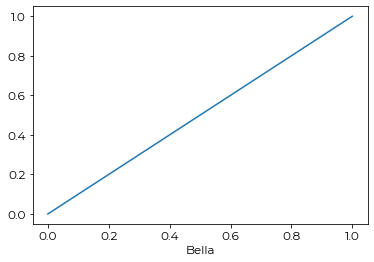

In [1750]:
plt.plot([0,1],[0,1])
plt.xlabel('Bella')

In [1787]:
# Check date and make theme homogenous -> all strings 
from datetime import datetime
for i,date in enumerate(df['Date']):
    if type(date) == str:
        date_time = datetime(int(date.split('/')[2]), int(date.split('/')[0]), int(date.split('/')[1]), 0, 0)
        df.at[i,'Date'] = date_time
df = df_tes = df.sort_values(by = 'Date')